In [6]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Subset, DataLoader, TensorDataset

import torchvision
import torchvision.transforms as transforms

import time
import copy
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [7]:
print(torch.cuda.is_available())
device_properties = torch.cuda.get_device_properties(0)

print(device_properties)

# _CudaDeviceProperties(name='Z100SM', major=7, minor=5, total_memory=16368MB, multi_processor_count=64)

True
_CudaDeviceProperties(name='Z100SM', major=7, minor=5, total_memory=16368MB, multi_processor_count=64)


In [45]:
import wandb
wandb.init(
    # set the wandb project where this run will be logged
    project="hypothesis",
    config={
    "architecture": "CNN",
    "dataset": "CIFAR-10",
    }
)

epoch,▁▁▂▂▃▃▄▄▅▅▅▅▆▆▇▇█
model12_cossim,█▆▅▄▃▂▂▁
model12_l1,▁▃▅▅▆▇▇█
model1_2_f1_cnn.0.weight,▁▃▄▅▆▆▇█
model1_2_f1_cnn.10.weight,▁▄▄▅▆▆▇█
model1_2_f1_cnn.13.weight,▁▄▅▆▆▇▇█
model1_2_f1_cnn.3.weight,▁▄▅▆▆▇██
model1_2_f1_cnn.6.weight,▁▄▅▆▆▇▇█
model1_base_cossim_cnn.0.weight,█▇▆▅▄▃▂▁
model1_base_cossim_cnn.10.weight,█▆▅▄▃▂▂▁
model1_base_cossim_cnn.13.weight,█▅▄▃▂▂▁▁


In [9]:
batch_size = 128
ratio = 0.1 # 控制抽取的百分比比例
alpha = 0.5  # 控制融合的比例，比例越高，原始图片的信息越多


transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
cifar10_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
validate_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

num_samples = len(cifar10_dataset)

subset_size = int(ratio * num_samples)
all_indices = list(range(num_samples))
random.shuffle(all_indices)
subset_indices = all_indices[:subset_size]   # 指定比例的数据索引
remaining_indices = all_indices[subset_size:]  # 剩下数据的索引

# 按照抽取的索引创建子集
subset_dataset = Subset(cifar10_dataset, subset_indices)

fusion_image = Image.open('hellokitty.png').resize((32, 32))
fusion_image = transforms.ToTensor()(fusion_image)

fused_images = []
fused_labels = []

# 对每张图片进行融合
for img, label in DataLoader(subset_dataset, batch_size=1):
    img_fused = alpha * img + (1 - alpha) * fusion_image.unsqueeze(0)
    # img_fused = img_fused.clamp(0, 1)
    fused_images.append(img_fused.squeeze(0))
    fused_labels.append(label)

fused_images = torch.stack(fused_images)
fused_labels = torch.tensor(fused_labels).squeeze()

# 创建包含融合图片的数据集
fused_dataset = TensorDataset(fused_images, fused_labels)

# 剩余的数据集
remaining_dataset = Subset(cifar10_dataset, remaining_indices)

# 合并剩余数据和融合图片后的数据
remaining_loader = DataLoader(remaining_dataset, batch_size=len(remaining_dataset), shuffle=False)
remaining_images, remaining_labels = next(iter(remaining_loader))

# 合并所有数据
final_images = torch.cat((remaining_images, fused_images), dim=0)
final_labels = torch.cat((remaining_labels, fused_labels), dim=0)

# 加载到新的数据集
final_dataset = TensorDataset(final_images, final_labels)


#
# 构造dataloader
#

# 只包含毒性数据的dataloader，只用来做可视化测试，不参与训练和验证
only_posion_loader = DataLoader(fused_dataset, batch_size=batch_size, shuffle=True)

# 正常数据
benign_trainloader = DataLoader(remaining_dataset, batch_size=batch_size, shuffle=True)

# 正常数据 + 包含固定比例的毒害数据
poison_trainloader = DataLoader(final_dataset, batch_size=batch_size, shuffle=True)

# 正常数据，用于验证
valloader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(len(only_posion_loader.dataset))
print(len(benign_trainloader.dataset))
print(len(poison_trainloader.dataset))
print(len(valloader.dataset))

Files already downloaded and verified
Files already downloaded and verified
5000
45000
50000
10000


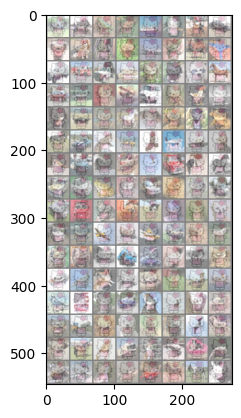

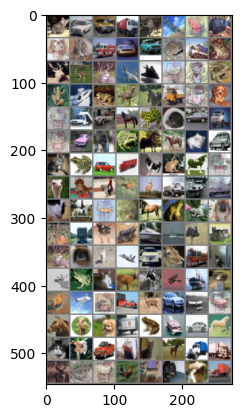

In [10]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(only_posion_loader)
images, _ = next(dataiter)
imshow(torchvision.utils.make_grid(images))

dataiter = iter(poison_trainloader)
images, _ = next(dataiter)
imshow(torchvision.utils.make_grid(images))

# print labels
# print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [11]:
computing_device = "cuda"

class CNN(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        # self.cnn = nn.Sequential(
        #     nn.Conv2d(3, 6, 5),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, 2),

        #     nn.Conv2d(6, 16, 5),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, 2),

        #     nn.Flatten(),
        #     nn.Linear(16 * 5 * 5, 256),
        #     nn.ReLU(),
        #     nn.Dropout(0.3),
        #     nn.Linear(256, 128),
        #     nn.ReLU(),
        #     nn.Linear(128, 10),
        #     nn.Sigmoid(),
        # )

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        return self.cnn(x)


In [46]:
lr = 0.0001
lambda_value = 0.01

# 基准模型，不参与训练
base_model = CNN().to(computing_device)

# 模型在正常数据集上训练
model1 = copy.deepcopy(base_model)
loss_fn1 = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=lr, weight_decay=lambda_value)

# 模型在正常数据集+异常数据上训练
model2 = copy.deepcopy(base_model)
loss_fn2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=lr, weight_decay=lambda_value)

# 模型在正常数据+毒害数据上训练
# model3 = copy.deepcopy(base_model)
# loss_fn3 = nn.CrossEntropyLoss()
# optimizer3 = torch.optim.SGD(model3.parameters(), lr=lr)

print(sum(p.numel() for p in base_model.parameters()))   # 查看一下模型参数量

620362


In [47]:
# model1在正常数据上训练，model2在正常+毒害上训练
dataloaders = [benign_trainloader, poison_trainloader]

models = [model1, model2]
loss_fns = [loss_fn1, loss_fn2]
optimizers = [optimizer1, optimizer2]

# 添加一下 模型的权重层名称 只添加weight 不添加bias
model_layers = []
for k in model1.state_dict():
    if k.find("bias") >= 1:
        continue
    model_layers.append(k)
print(model_layers)

['cnn.0.weight', 'cnn.3.weight', 'cnn.6.weight', 'cnn.10.weight', 'cnn.13.weight']


In [48]:
# 随便挑一个数据查看一下输入输出维度
tmpdata = torch.randn([1, 1, 1])
for X, y in valloader:
    # print(X.size())
    # print(y.size())
    print(y)
    tmpdata = X.to(computing_device)
    break

y = y.to(computing_device)
print(tmpdata.size())
res = model1(tmpdata)

# print(res.size())

print(res.argmax(1))
print(y)
print((res.argmax(1) == y).type(torch.float).sum().item() )

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6,
        8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6,
        6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 3, 6, 8, 7, 4, 0, 6, 2, 1, 3, 0, 4, 2, 7,
        8, 3, 1, 2, 8, 0, 8, 3])
torch.Size([128, 3, 32, 32])
tensor([2, 8, 8, 2, 8, 2, 5, 2, 1, 2, 2, 8, 2, 1, 2, 1, 3, 8, 5, 5, 5, 2, 1, 8,
        2, 5, 2, 1, 5, 1, 2, 8, 2, 8, 1, 8, 8, 1, 8, 2, 2, 5, 1, 2, 8, 2, 8, 2,
        3, 2, 8, 2, 5, 5, 2, 2, 5, 2, 8, 2, 8, 8, 1, 2, 2, 8, 2, 1, 1, 1, 8, 8,
        2, 2, 8, 1, 5, 8, 3, 1, 2, 8, 2, 8, 2, 1, 3, 2, 2, 8, 8, 1, 1, 8, 8, 5,
        2, 2, 1, 8, 8, 1, 2, 2, 1, 1, 5, 2, 8, 2, 2, 1, 8, 2, 1, 2, 5, 2, 2, 1,
        1, 2, 2, 8, 2, 2, 1, 5], device='cuda:0')
tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        

In [43]:
# 训练
def train_model(epoch, model, loss_fn, optimizer, trainloader):
    # training
    num_batches = len(trainloader)
    model.train()
    train_loss = 0
    for batch, (X, y) in enumerate(trainloader):
        X, y = X.to(computing_device), y.to(computing_device)
        optimizer.zero_grad()
        
        predict = model(X)

        loss = loss_fn(predict, y)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        
    train_loss /= num_batches

    return train_loss

# 验证
def val_model(epoch, model, loss_fn, valloader):
    size = len(valloader.dataset)
    num_batches = len(valloader)
    
    model.eval()
    test_loss, val_correct = 0, 0
    with torch.no_grad():        
        for batch, (X, y) in enumerate(valloader):
            X, y = X.to(computing_device), y.to(computing_device)

            predict = model(X)
            loss = loss_fn(predict, y)
            test_loss += loss.item()
            val_correct += (predict.argmax(1) == y).type(torch.float).sum().item() 
            
    test_loss /= num_batches
    val_correct /= size

    return test_loss, val_correct

# 测试
def test_model(model, loss_fn, testloader):
    pass


In [44]:
start_epoch = 0 # 从哪一个epoch开始
num_epochs = 32 # 要训练多少个epoch

# time_all = 0    # 消耗的总时长，单位s

for epoch in range(start_epoch, start_epoch + num_epochs):
    # size = len(testloader.dataset)

    print(f"Epoch {epoch}")
    # 训练多个模型
    for idx, _ in enumerate(models):
        wandb.log({"epoch": epoch})


        ts = time.perf_counter() # 打一个时间戳

        train_loss = train_model(epoch, models[idx], loss_fns[idx], optimizers[idx], dataloaders[idx])
        val_loss, val_correct = val_model(epoch, models[idx], loss_fns[idx], valloader)

        td = time.perf_counter()    # 打一个时间戳
        # time_all += (td - ts)

        print(f"Model {idx+1} | TrainLoss {train_loss:.5f} | ValLoss {val_loss:.5f} | ValCorrect {val_correct:.5f}| EpochTime {(td - ts):.5f}s")
        wandb.log({f"model_{idx+1}_train_loss": train_loss, f"model_{idx+1}_val_loss": val_loss, f"model_{idx+1}_val_correct": val_correct})

        # visdom.line(np.array([train_loss]), np.array([epoch]), win=f"Model {idx} Train Loss", update="append", opts={"title": f"Model {idx} Train Loss"})
        # visdom.line(np.array([val_loss]), np.array([epoch]), win=f"Model {idx} Val Loss", update="append", opts={"title": f"Model {idx} Val Loss"})

    # 测量model1和base_model的余弦相似度距离
    # 测量model2和base_model的余弦相似度距离
    model_base_params = torch.cat([p.view(-1) for p in base_model.parameters()])
    model_tmp1_params = torch.cat([p.view(-1) for p in model1.parameters()])
    model_tmp2_params = torch.cat([p.view(-1) for p in model2.parameters()])

    model1base_cossim = F.cosine_similarity(model_base_params.unsqueeze(0), model_tmp1_params.unsqueeze(0)).item()
    model2base_cossim = F.cosine_similarity(model_base_params.unsqueeze(0), model_tmp2_params.unsqueeze(0)).item()
    model12_cossim = F.cosine_similarity(model_tmp1_params.unsqueeze(0), model_tmp2_params.unsqueeze(0)).item()

    print(f"model1base_cossim: {model1base_cossim}, model2base_cossim: {model2base_cossim}, model12_cossim: {model12_cossim}")
    wandb.log({"model1base_cossim": model1base_cossim, "model2base_cossim": model2base_cossim, "model12_cossim": model12_cossim})
    
    model1base_l1 = F.pairwise_distance(model_base_params.unsqueeze(0), model_tmp1_params.unsqueeze(0)).item()
    model2base_l1 = F.pairwise_distance(model_base_params.unsqueeze(0), model_tmp2_params.unsqueeze(0)).item()
    model12_l1 = F.pairwise_distance(model_tmp1_params.unsqueeze(0), model_tmp2_params.unsqueeze(0)).item()
    print(f"model1base_l1: {model1base_l1}, model2base_l1: {model2base_l1}, model12_l1: {model12_l1}")
    wandb.log({"model1base_l1": model1base_l1, "model2base_l1": model2base_l1, "model12_l1": model12_l1})
    

    # 测量model1与base_model之间层的相似度
    for idx, k, in enumerate(model_layers):
        tensor_base = base_model.state_dict()[k].flatten()
        tensor_tmp = model1.state_dict()[k].flatten()
        layer_cos_sim = F.cosine_similarity(tensor_base.unsqueeze(0), tensor_tmp.unsqueeze(0)).item()
        layer_f1 = F.pairwise_distance(tensor_base.unsqueeze(0), tensor_tmp.unsqueeze(0)).item()
        # print(f"Model 1 and base, {k}, {layer_cos_sim}")
        wandb.log({f"model1_base_cossim_{k}": layer_cos_sim, f"model1_base_f1_{k}": layer_f1})

    # 测量model2与base_model之间层的相似度
    for idx, k, in enumerate(model_layers):
        tensor_base = base_model.state_dict()[k].flatten()
        tensor_tmp = model2.state_dict()[k].flatten()
        layer_cos_sim = F.cosine_similarity(tensor_base.unsqueeze(0), tensor_tmp.unsqueeze(0)).item()
        layer_f1 = F.pairwise_distance(tensor_base.unsqueeze(0), tensor_tmp.unsqueeze(0)).item()
        # print(f"Model 2 and base, {k}, {layer_cos_sim}")
        wandb.log({f"model2_base_cossim_{k}": layer_cos_sim, f"model2_base_f1_{k}": layer_f1})
        
    # 测量model1与model2之间层的相似度
    for idx, k, in enumerate(model_layers):
        tensor_tmp1 = model1.state_dict()[k].flatten()
        tensor_tmp2 = model2.state_dict()[k].flatten()
        layer_cos_sim = F.cosine_similarity(tensor_tmp1.unsqueeze(0), tensor_tmp2.unsqueeze(0)).item()
        layer_f1 = F.pairwise_distance(tensor_tmp1.unsqueeze(0), tensor_tmp2.unsqueeze(0)).item()
        # print(f"Model 2 and base, {k}, {layer_cos_sim}")
        wandb.log({f"model2_base_{k}": layer_cos_sim, f"model1_2_f1_{k}": layer_f1})

    # print(f"Epoch: {epoch} | TrainLoss: {train_loss:.5f} | ValLoss: {test_loss:.5f} | EpochTime: {(td - ts):.5f}s ｜ TimeRemaining: {(time_all / (epoch - start_epoch + 1)) * (start_epoch + num_epochs - epoch - 1):.5f}s")
    print("----- ----- ----- ----- -----")


Epoch 0
Model 1 | TrainLoss 1.99518 | ValLoss 1.73066 | ValCorrect 0.38680| EpochTime 16.98657s
Model 2 | TrainLoss 1.99758 | ValLoss 1.72399 | ValCorrect 0.38030| EpochTime 5.33803s
model1base_cossim: 0.7803235650062561, model2base_cossim: 0.7602967023849487, model12_cossim: 0.9583157896995544
model1base_l1: 8.305463790893555, model2base_l1: 8.588397979736328, model12_l1: 2.2274906635284424
----- ----- ----- ----- -----
Epoch 1
Model 1 | TrainLoss 1.67760 | ValLoss 1.58093 | ValCorrect 0.42850| EpochTime 16.94040s
Model 2 | TrainLoss 1.69127 | ValLoss 1.53348 | ValCorrect 0.44520| EpochTime 5.26809s
model1base_cossim: 0.6632812023162842, model2base_cossim: 0.6375294327735901, model12_cossim: 0.9366821050643921
model1base_l1: 9.63649845123291, model2base_l1: 9.896946907043457, model12_l1: 2.638169288635254
----- ----- ----- ----- -----
Epoch 2
Model 1 | TrainLoss 1.56347 | ValLoss 1.49468 | ValCorrect 0.46020| EpochTime 16.89883s
Model 2 | TrainLoss 1.57494 | ValLoss 1.47704 | ValCorre

KeyboardInterrupt: 